In [1]:
import earthnet_minicuber
import rasterio
import matplotlib.pyplot as plt


In [2]:
specs = {
    "lon_lat": (41.24493301281836, 0.5917756199210684), # center pixel
    "xy_shape": (512, 512), # width, height of cutout around center pixel
    "resolution": 30, # in meters.. will use this together with grid of primary provider..
    "time_interval": "2021-01-01/2021-02-01",
    "primary_provider": {
    "name": "s2",
    "kwargs": {"bands": ["B02", "B03", "B04"], "best_orbit_filter": True, "brdf_correction": True, "cloud_mask": True}
    },
    "other_providers": []
}

In [3]:
cube = earthnet_minicuber.Minicuber.load_minicube(specs)

/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:413: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  xs = pd.Float64Index(np.linspace(minx, maxx, width, endpoint=False))
/Net/Groups/BGI/people/vbenson/miniconda3/envs/dea/lib/python3.9/site-packages/stackstac/prepare.py:414: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  ys = pd.Float64Index(np.linspace(maxy, miny, height, endpoint=False))
/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-minicuber/earthnet_minicuber/provider/s2/utils.py:195: RuntimeWarning: Mean of empty slice
  bands_dict[band]["Zenith"] = np.nanmean(
/Net/Groups/BGI/people/vbenson/EarthNet/earthnet-minicuber/earthnet_minicuber/provider/s2/utils.py:198: RuntimeWarning: Mean of empty slice
  bands_dict[b

Requesting data:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
cube

<xarray.Dataset>
Dimensions:  (time: 6, lat: 512, lon: 512)
Coordinates:
  * time     (time) datetime64[ns] 2021-01-05T07:49:44 ... 2021-01-30T07:49:44
  * lon      (lon) float64 41.18 41.18 41.18 41.18 ... 41.31 41.31 41.31 41.31
  * lat      (lat) float64 0.6612 0.661 0.6607 0.6604 ... 0.5229 0.5226 0.5223
Data variables:
    s2_mask  (time, lat, lon) float64 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    s2_B02   (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    s2_B03   (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    s2_B04   (time, lat, lon) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [15]:
%env AWS_NO_SIGN_REQUEST=True
%env AWS_S3_ENDPOINT='s3.af-south-1.amazonaws.com'

env: AWS_NO_SIGN_REQUEST=True
env: AWS_S3_ENDPOINT='s3.af-south-1.amazonaws.com'


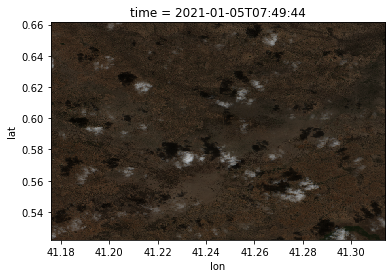

In [17]:
with rasterio.Env(aws_unsigned = True, AWS_S3_ENDPOINT= 's3.af-south-1.amazonaws.com'):
    (cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0)).plot.imshow(rgb="band")

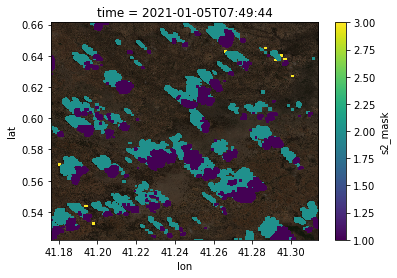

In [18]:
with rasterio.Env(aws_unsigned = True, AWS_S3_ENDPOINT= 's3.af-south-1.amazonaws.com'):
    (cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = 0)).plot.imshow(rgb="band")
    cube["s2_mask"].isel(time=0).where(lambda x: x>0).plot.imshow(ax = plt.gca())